<a href="https://colab.research.google.com/github/marcusbrito/weather-station/blob/master/ts_inmet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing libraries

from google.colab import files
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline


import statsmodels.api as sm

mpl.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt, log10
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint

from keras import backend

import random
from collections import deque

import time
import math

In [0]:
#Loading the dataset

#uploaded = files.upload()
df = pd.read_excel("dados_inmet_natal5.xlsx")

In [0]:
df.head()

,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
0,01/01/1992,0,NaN,30.2,NaN,8.8,27.26,75.25,5.800000
1,01/01/1992,1200,1.8,NaN,25.1,NaN,NaN,NaN,NaN
2,02/01/1992,0,NaN,30.0,NaN,9.4,27.58,75.00,5.533333
3,02/01/1992,1200,0.0,NaN,26.3,NaN,NaN,NaN,NaN
4,03/01/1992,0,NaN,30.2,NaN,9.1,27.70,74.50,5.833333


In [0]:
#Setting Date as index

df["Data"] = pd.to_datetime(df["Data"], format="%d/%m/%Y")
df.set_index('Data', inplace = True)

In [0]:
#Changing columns names to make df manipulation easier

df.columns = ['hour', 'precip', 'temp_max', 'temp_min', 'radiation', 'temp_avg', 'humid', 'wind_spd']

In [0]:
#Filling missing average temperatures with (max + min)/2

j = 0

for i in df.temp_avg:
  if math.isnan(i):
    df.temp_avg.iloc[j] = (df.temp_max.iloc[j] + df.temp_min.iloc[j])/2
  j +=1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#Putting data in the right format

df0 = df[['precip', 'temp_min']]
df0 = df0.groupby(by = df0.index).max()

df1 = df[['temp_max', 'radiation', 'temp_avg', 'humid', 'wind_spd']]
df1 = df1.groupby(by = df1.index).max()

df = df0.join(df1)

In [0]:
df.head()

,precip,temp_min,temp_max,radiation,temp_avg,humid,wind_spd
Data,,,,,,,
1992-01-01,1.8,25.1,30.2,8.8,27.26,75.25,5.800000
1992-01-02,0.0,26.3,30.0,9.4,27.58,75.00,5.533333
1992-01-03,0.0,26.1,30.2,9.1,27.70,74.50,5.833333
1992-01-04,0.0,26.0,30.2,9.2,27.44,75.75,5.366667
1992-01-05,0.0,26.1,30.2,9.9,27.38,77.75,4.866667


In [0]:
#Filling missing values with interpolation

df.interpolate(method='linear',inplace=True)

In [0]:
#Applying log(x+1) to correct skewness

df_log = df
for j in df.columns:
   df_log['{}'.format(j)] = df_log['{}'.format(j)].apply(lambda x: np.log1p(x))

In [0]:
df_log.head()

,precip,temp_min,temp_max,radiation,temp_avg,humid,wind_spd
Data,,,,,,,
1992-01-01,1.029619,3.261935,3.440418,2.282382,3.341447,4.334017,1.916923
1992-01-02,0.000000,3.306887,3.433987,2.341806,3.352707,4.330733,1.876917
1992-01-03,0.000000,3.299534,3.440418,2.312535,3.356897,4.324133,1.921813
1992-01-04,0.000000,3.295837,3.440418,2.322388,3.347797,4.340553,1.851076
1992-01-05,0.000000,3.299534,3.440418,2.388763,3.345685,4.366278,1.769287


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29e2e11cf8>],
      dtype=object)

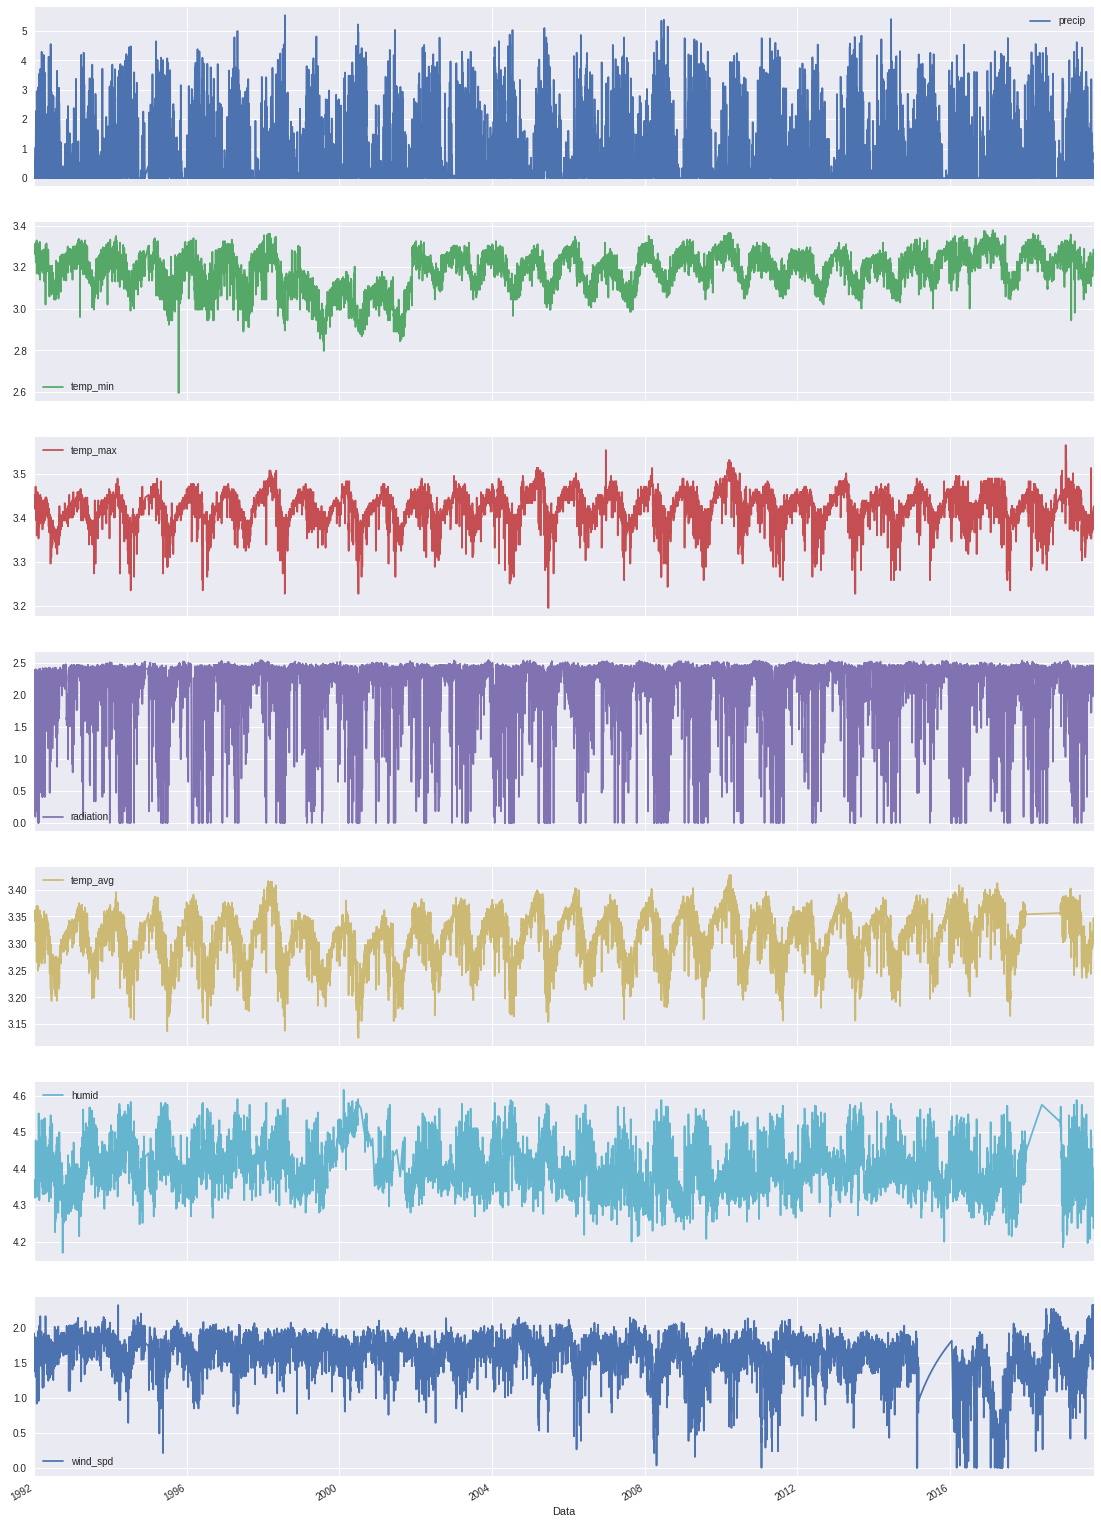

In [0]:
#Seeing how the series looks like

df.plot(subplots=True, layout=(7,1), figsize=[19, 30])


In [0]:
#Normalazing data

#df_new = (df - df.min())/(df.max() - df.min())
df_new = (df_log - df_log.mean())/df_log.std()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a58a9bef0>,
      dtype=object)

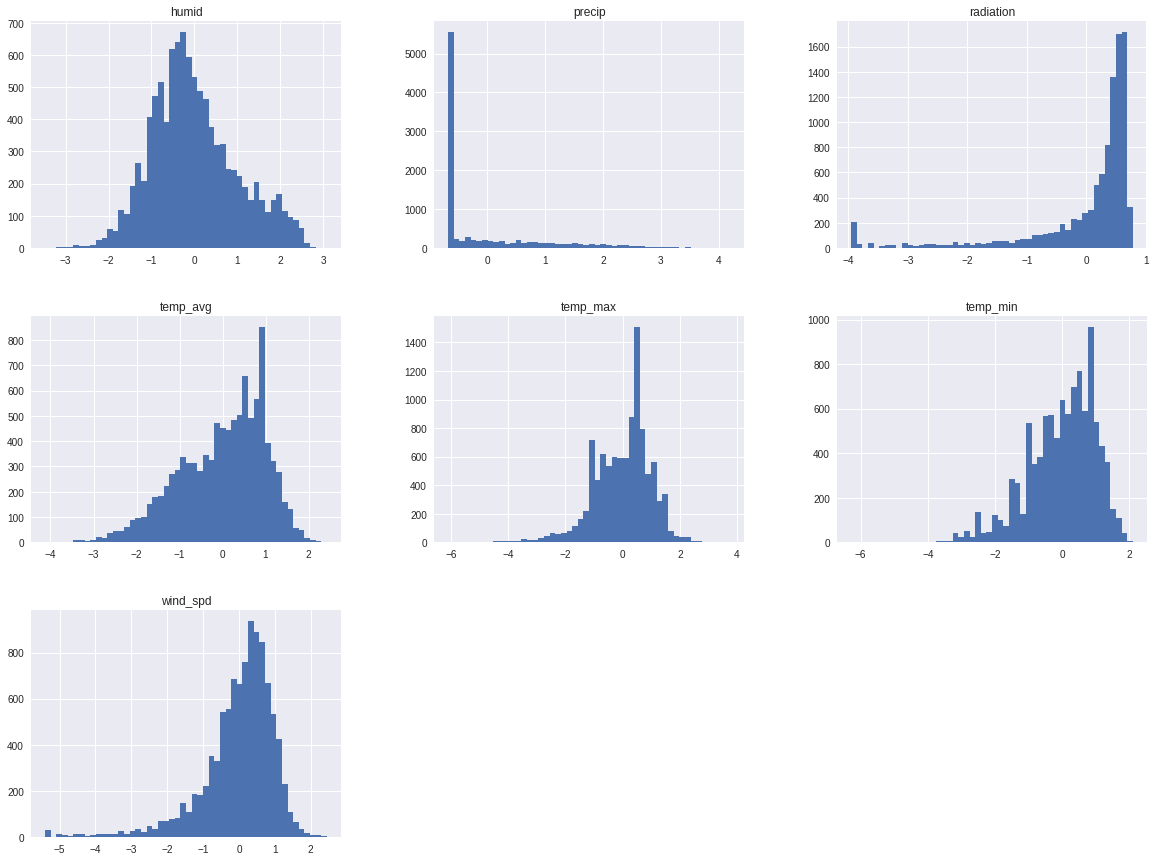

In [0]:
#Looking at data distribuition

df_new.hist(bins=50, figsize=(20,15)) 


#plt.show()

In [0]:
#Checking for linear correlation between the variables

df_new.corr()

,precip,temp_min,temp_max,radiation,temp_avg,humid,wind_spd
precip,1.000000,-0.240653,-0.394101,-0.493872,-0.372629,0.446876,-0.306642
temp_min,-0.240653,1.000000,0.557831,0.163078,0.797243,-0.321786,-0.121372
temp_max,-0.394101,0.557831,1.000000,0.499294,0.849858,-0.425077,0.049630
radiation,-0.493872,0.163078,0.499294,1.000000,0.390143,-0.477165,0.342202
temp_avg,-0.372629,0.797243,0.849858,0.390143,1.000000,-0.414264,-0.028477
humid,0.446876,-0.321786,-0.425077,-0.477165,-0.414264,1.000000,-0.240287
wind_spd,-0.306642,-0.121372,0.049630,0.342202,-0.028477,-0.240287,1.000000


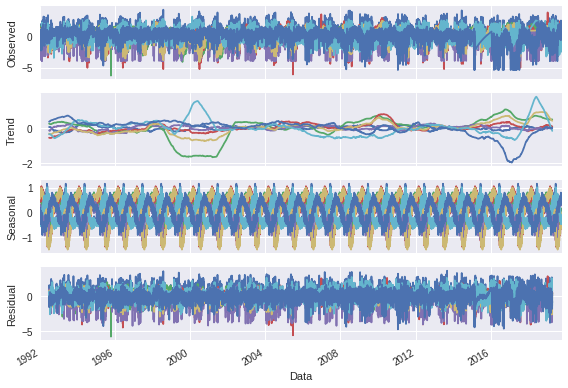

In [0]:
#Decomposing the dataset in Trend, Seasonal and Residual components

decomp = sm.tsa.seasonal_decompose(df_new,freq=365,model="additive")
decomp.plot();

In [0]:
#Removing seasonal component. As the linear trend is very close to zero for all series, it will be mantained.

df_final = decomp.resid.dropna()
#df_final = (df_new - decomp.seasonal)
df_final = pd.DataFrame(df_final)
df_final.columns = ['precip', 'temp_min', 'temp_max', 'radiation', 'temp_avg', 'humid', 'wind_spd']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29cf661a20>],
      dtype=object)

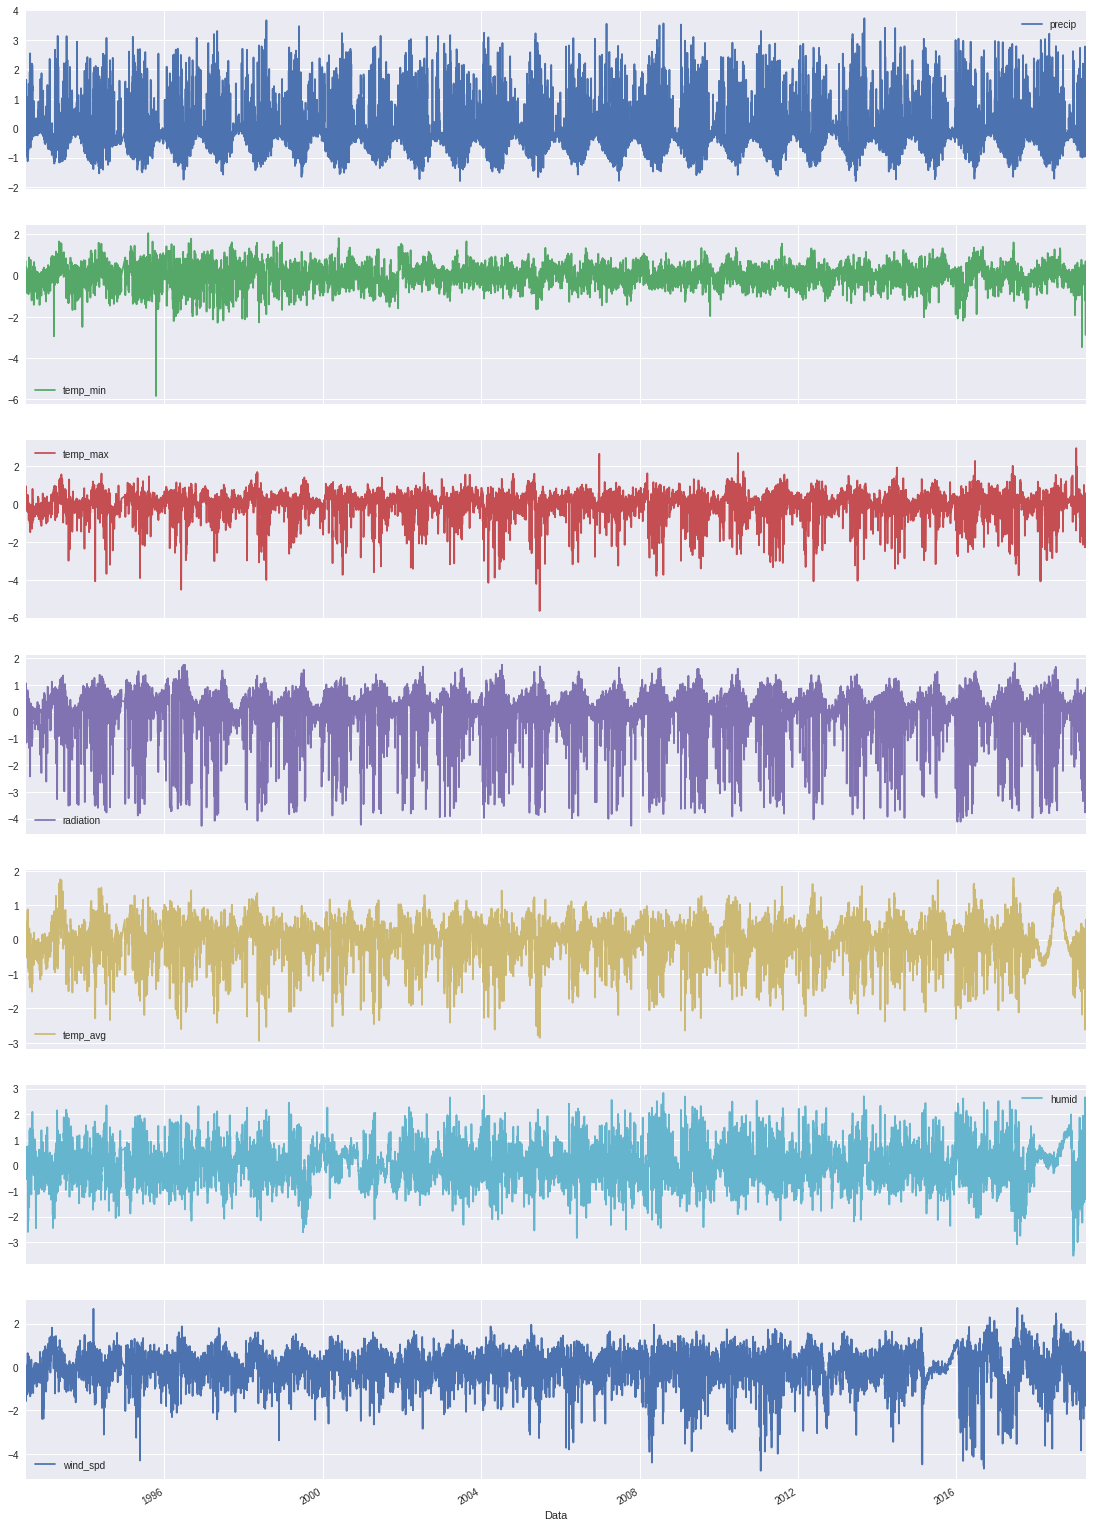

In [0]:
df_final.plot(subplots=True, layout=(7,1), figsize=[19, 30])


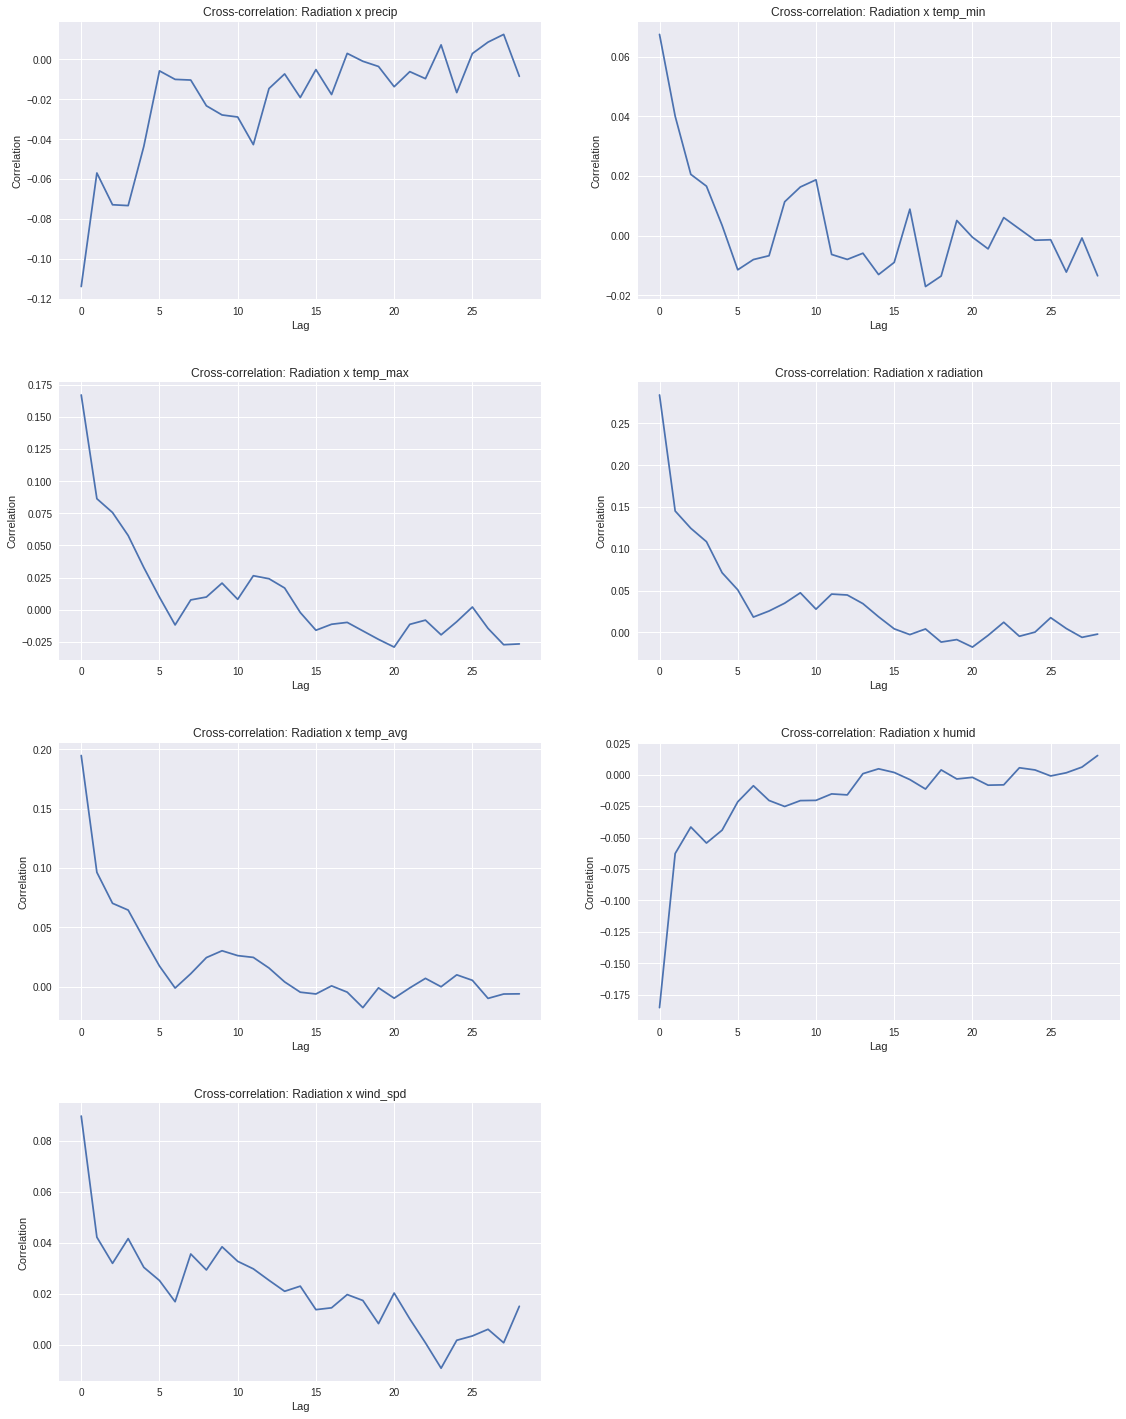

In [0]:
#Checking cross-correlation between radiation and the other columns
plt.subplots(figsize=(19, 25))
plt.subplots_adjust(hspace = 0.3)
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

j = 1
for column in df_final.columns:
  cross_corr = []
  for i in range(1,30):
    cross_corr.append(crosscorr(df_final.radiation, df_final[column], i))
  
  plt.subplot(4,2,j)
  plt.plot(cross_corr)
  plt.xlabel('Lag')
  plt.ylabel('Correlation')
  plt.title('Cross-correlation: Radiation x {}'.format(column))
  plt.grid(True)
  j +=1


plt.show()

  
    

In [0]:
#Dropping columns with low cross-correlation with the radiaiton

df_final.drop(columns=['temp_min', 'wind_spd'], inplace=True)

In [0]:
df_final.head()

,precip,temp_max,radiation,temp_avg,humid
Data,,,,,
1992-07-01,-0.554374,0.438132,0.667236,0.848240,0.073165
1992-07-02,-0.548511,0.933647,1.063423,0.609291,-0.424860
1992-07-03,-0.969097,0.900795,0.857058,0.444502,-0.414962
1992-07-04,-0.725050,0.626474,0.410201,0.085958,-0.129296
1992-07-05,-0.773741,-0.108614,0.156993,0.110596,0.635630


In [0]:
FUTURE_WINDOW = 1

In [0]:
#Spliting dataset into train and test

df_train, df_test = train_test_split(df_final, test_size=0.2, shuffle = False)

In [0]:
#Defining error metric funcion. Root squared mean error(RMSE).
def rmse(data_x, data_y):
  return sqrt(mean_squared_error(data_x, data_y))

In [0]:
#Calculating the error if we simply repeat the value of the previous day. It will serve as base for comparison for the other methods

rms_naive = rmse(df_test.radiation.values[:-FUTURE_WINDOW], df_test.radiation.shift(-FUTURE_WINDOW).values[:-FUTURE_WINDOW])
print('Naive method - RMSE: {}'.format(rms_naive))

Naive method - RMSE: 1.1298463806866068


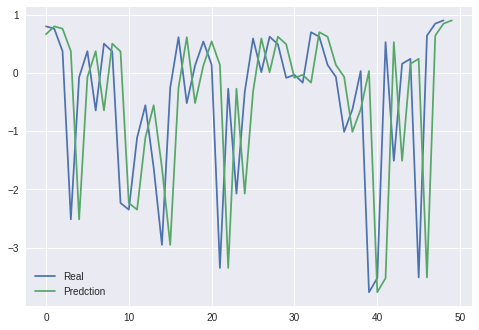

In [0]:
plt.plot(df_test.radiation.shift(-FUTURE_WINDOW).values[-50:])
plt.plot(df_test.radiation.values[-50:])


plt.legend(['Real', 'Predction'])

plt.show()


In [0]:
#Creating tradional statiscal model for time series forecast
from statsmodels.tsa.api import VAR

model = VAR(df_train)

results = model.fit(maxlags=50, ic='aic')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
PAST_WINDOW  = results.k_ar
pred_var = []

for i in range(len(df_test) - PAST_WINDOW):
  pred_var.append(results.forecast(df_test.values[i:i+PAST_WINDOW], 1))

pred_var = np.reshape(np.array(pred_var), (len(pred_var), 5))

In [0]:
rms_var = rmse(df_test.radiation.values[PAST_WINDOW:], pred_var[:,2])
print('ARIMA - RMSE: {}'.format(rms_var))
print('ARIMA/Naive RMSE ration: {}'.format(rms_var/rms_naive))

ARIMA - RMSE: 0.905711021431022
ARIMA/Naive RMSE ration: 0.8016231559556106


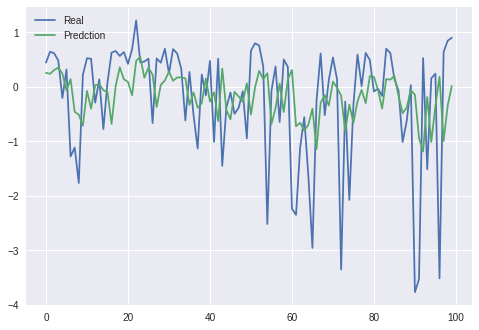

In [0]:
plt.plot(df_test.radiation.values[-100:])
plt.plot(pred_var[-100:,2])

plt.legend(['Real', 'Predction'])

plt.show()

In [0]:
def create_seq_data(df):
  sequential_data = []  # this is a list that will CONTAIN the sequences
  prev_days = deque(maxlen = PAST_WINDOW)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in df.values:  # iterate over the values
    prev_days.append([n for n in i[:-1]])  # store all but the target
    if len(prev_days) == PAST_WINDOW:  # make sure we have 60 sequences!
      sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

  #random.shuffle(sequential_data)  # shuffle for good measure.

  X = []
  y = []

  for seq, target in sequential_data:  # going over our new sequential data
    X.append(seq)  # X is the sequences
    y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

  return np.array(X), np.array(y)

In [0]:
df_train_y = df_train.join(df_train.radiation.shift(-FUTURE_WINDOW),rsuffix='_futur').dropna()
df_test_y = df_test.join(df_test.radiation.shift(-FUTURE_WINDOW),rsuffix='_futur').dropna()

x_train, y_train = create_seq_data(df_train_y)
x_test, y_test = create_seq_data(df_test_y)

In [0]:
#Creating deep learning model LSTM

model = Sequential()
model.add(CuDNNLSTM(16, input_shape=(x_train.shape[1:])))
#model.add(Dropout(0.2))
#model.add(BatchNormalization()) 

#model.add(CuDNNLSTM(8))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

#model.add(CuDNNLSTM(32))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(8, activation='relu'))

model.add(Dense(4, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

In [0]:
model.compile(
  loss='mse',
  optimizer='adam',
  metrics = ['mae']
)

In [0]:
#Training the model

NAME = f"{PAST_WINDOW}-SEQ-{FUTURE_WINDOW}-PRED-{int(time.time())}"

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "RNN_Final-{epoch:02d}-{val_mean_absolute_error:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='rmse', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

history = model.fit(
    x_train, y_train,
    batch_size=1024,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard, checkpoint]
)

Train on 7786 samples, validate on 1938 samples
Epoch 1/100
7786/7786 [==============================] - 1s 87us/sample - loss: 0.8489 - mean_absolute_error: 0.6139 - val_loss: 0.8561 - val_mean_absolute_error: 0.6186
Epoch 2/100
7786/7786 [==============================] - 0s 11us/sample - loss: 0.8365 - mean_absolute_error: 0.6027 - val_loss: 0.8484 - val_mean_absolute_error: 0.6120
Epoch 3/100
7786/7786 [==============================] - 0s 11us/sample - loss: 0.8272 - mean_absolute_error: 0.5972 - val_loss: 0.8415 - val_mean_absolute_error: 0.6081
Epoch 4/100
7786/7786 [==============================] - 0s 10us/sample - loss: 0.8165 - mean_absolute_error: 0.5917 - val_loss: 0.8362 - val_mean_absolute_error: 0.6042
Epoch 5/100
7786/7786 [==============================] - 0s 9us/sample - loss: 0.8073 - mean_absolute_error: 0.5859 - val_loss: 0.8320 - val_mean_absolute_error: 0.6004
Epoch 6/100
7786/7786 [==============================] - 0s 11us/sample - loss: 0.7981 - mean_absolute_

In [0]:
pred_lstm = model.predict(x_test)

In [0]:
rms_lstm = rmse(y_test, pred_lstm)
print('LSTM - RMSE: {}'.format(rms_lstm))
print('LSTM/Naive RMSE ration: {}'.format(rms_lstm/rms_naive))

LSTM - RMSE: 0.9148455608892385
LSTM/Naive RMSE ration: 0.8097079182864555


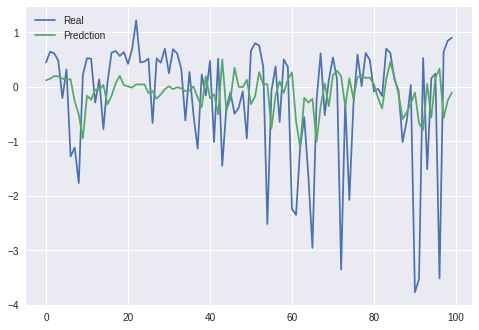

In [0]:
plt.plot(y_test[-100:])
plt.plot(pred_lstm[-100:])

plt.legend(['Real', 'Predction'])
plt.show()

plt.rcParams['figure.figsize'] = [19, 8]

In [0]:
#!zip -r /content/logs.zip /content/logs